In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.optimizers import Adam


2023-04-25 22:42:52.812083: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define data generators for training and validation sets
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('data/train', target_size=(224, 224), batch_size=32, class_mode='categorical')
val_generator = val_datagen.flow_from_directory('data/test', target_size=(224, 224), batch_size=32, class_mode='categorical')

Found 1951 images belonging to 4 classes.
Found 18 images belonging to 4 classes.


In [3]:
# Load the pre-trained VGG16 model and remove the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

2023-04-25 22:43:35.892731: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Add new top layers for classification
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

In [5]:
# Create the final model by combining base and top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


/Users/anujshah/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
# Train the model
history = model.fit(train_generator, epochs=10, steps_per_epoch=61, validation_data=val_generator, validation_steps=1)

Epoch 1/10
61/61 [==============================] - 225s 4s/step - loss: 0.6264 - accuracy: 0.7560 - val_loss: 0.4435 - val_accuracy: 0.8333
Epoch 2/10
61/61 [==============================] - 282s 5s/step - loss: 0.2535 - accuracy: 0.9108 - val_loss: 0.1208 - val_accuracy: 0.9444
Epoch 3/10
61/61 [==============================] - 315s 5s/step - loss: 0.1880 - accuracy: 0.9323 - val_loss: 0.1648 - val_accuracy: 0.9444
Epoch 4/10
61/61 [==============================] - 546s 9s/step - loss: 0.1488 - accuracy: 0.9498 - val_loss: 0.0788 - val_accuracy: 0.9444
Epoch 5/10
61/61 [==============================] - 1182s 20s/step - loss: 0.1288 - accuracy: 0.9559 - val_loss: 0.2233 - val_accuracy: 0.8889
Epoch 6/10
61/61 [==============================] - 213s 3s/step - loss: 0.1084 - accuracy: 0.9662 - val_loss: 0.2014 - val_accuracy: 0.9444
Epoch 7/10
61/61 [==============================] - 275s 5s/step - loss: 0.0964 - accuracy: 0.9667 - val_loss: 0.0694 - val_accuracy: 0.9444
Epoch 8/10


In [7]:
# Save the trained model
model.save('plant_disease_detection.h5')

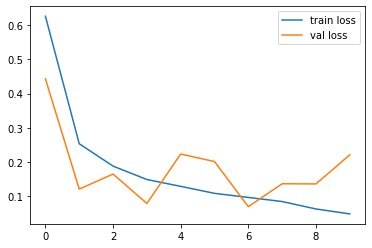

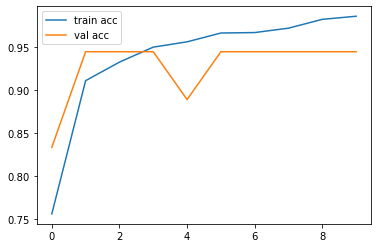

<Figure size 432x288 with 0 Axes>

In [18]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [8]:
# Load the saved model
from keras.models import load_model
model = load_model('plant_disease_detection.h5')

# Evaluate the model on the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('data/test', target_size=(224, 224), batch_size=1, class_mode='categorical', shuffle=False)
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy:', accuracy)


Found 18 images belonging to 4 classes.
18/18 [==============================] - 3s 167ms/step - loss: 0.2210 - accuracy: 0.9444
Test accuracy: 0.9444444179534912


In [13]:
from sklearn.metrics import classification_report

In [14]:
# Make predictions on the test data
test_pred = model.predict(test_generator)

# Get the predicted class labels
test_pred_labels = np.argmax(test_pred, axis=1)

# Get the true class labels
test_true_labels = test_generator.classes

18/18 [==============================] - 8s 458ms/step


In [16]:
# Print the classification report
print("*** VGG16 ***")
print(classification_report(test_true_labels, test_pred_labels))

*** VGG16 ***
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.83      1.00      0.91         5
           2       1.00      1.00      1.00         5
           3       1.00      0.80      0.89         5

    accuracy                           0.94        18
   macro avg       0.96      0.95      0.95        18
weighted avg       0.95      0.94      0.94        18



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.manifold import TSNE

2023-05-05 21:27:26.386388: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the saved model
model = load_model('plant_disease_detection.h5')

2023-05-05 21:27:33.746828: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Get the predicted classes and features for the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('data/val', target_size=(224, 224), batch_size=1, class_mode='categorical', shuffle=False)
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
features = model.predict(test_generator)

Found 324 images belonging to 4 classes.
324/324 [==============================] - 34s 104ms/step


In [4]:
# Apply t-SNE to the features
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(features)

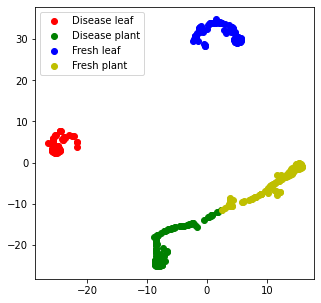

In [5]:
# Define a dictionary of cluster names
cluster_names = {0: 'Disease leaf', 1: 'Disease plant', 2: 'Fresh leaf', 3: 'Fresh plant'}

# Get the unique class labels
labels = np.unique(y_pred_classes)

# Plot the t-SNE visualization with cluster labels
plt.figure(figsize=(5, 5))
colors = ['r', 'g', 'b', 'y']
for label in labels:
    idx = np.where(y_pred_classes == label)[0]
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], c=colors[label], marker='o', label=cluster_names[label])
plt.legend()
plt.show()

In [6]:
from sklearn.metrics import confusion_matrix, classification_report

In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('data/test', target_size=(224, 224), batch_size=1, class_mode='categorical', shuffle=False)
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

Found 18 images belonging to 4 classes.
18/18 [==============================] - 3s 172ms/step


In [8]:
# Create and display the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

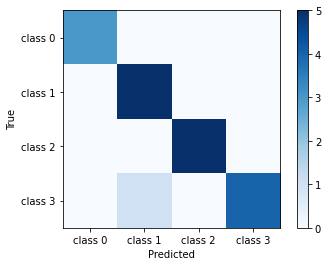

In [9]:
# Plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), ['class 0', 'class 1', 'class 2', 'class 3'])
plt.yticks(np.arange(4), ['class 0', 'class 1', 'class 2', 'class 3'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 [==============================] - 0s 219ms/step


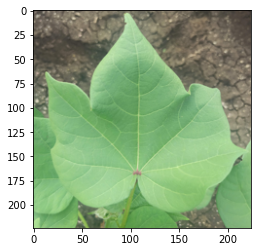

Predicted class: fresh leaf


In [10]:
import numpy as np
from PIL import Image
from keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('plant_disease_detection.h5')

# Set the path to the input image
img_path = 'healthy leaf.jpg'

# Load the input image and preprocess it
img = Image.open(img_path).resize((224, 224))
x = np.array(img) / 255.0  # normalize the pixel values
x = np.expand_dims(x, axis=0)

# Predict the class label for the input image
pred = model.predict(x)
pred_class = np.argmax(pred, axis=1)

# Get the predicted class name
class_names = ['disease leaf', 'disease plant', 'fresh leaf', 'fresh plant']  # replace with your class names
pred_class_name = class_names[pred_class[0]]

# Display the image
plt.imshow(img)
plt.show()

# Print the predicted class name
print("Predicted class:", pred_class_name)


1/1 [==============================] - 0s 196ms/step


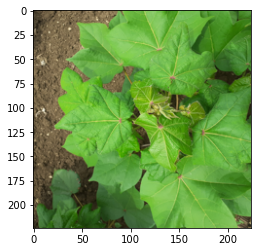

Predicted class: disease plant


In [11]:
import numpy as np
from PIL import Image
from keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('plant_disease_detection.h5')

# Set the path to the input image
img_path = 'disease plant.jpg'

# Load the input image and preprocess it
img = Image.open(img_path).resize((224, 224))
x = np.array(img) / 255.0  # normalize the pixel values
x = np.expand_dims(x, axis=0)

# Predict the class label for the input image
pred = model.predict(x)
pred_class = np.argmax(pred, axis=1)

# Get the predicted class name
class_names = ['disease leaf', 'disease plant', 'fresh leaf', 'fresh plant']  # replace with your class names
pred_class_name = class_names[pred_class[0]]

# Display the image
plt.imshow(img)
plt.show()

# Print the predicted class name
print("Predicted class:", pred_class_name)


1/1 [==============================] - 0s 206ms/step


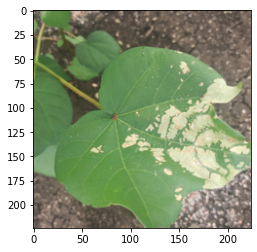

Predicted class: disease leaf


In [12]:
import numpy as np
from PIL import Image
from keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('plant_disease_detection.h5')

# Set the path to the input image
img_path = 'disease leaf.jpg'

# Load the input image and preprocess it
img = Image.open(img_path).resize((224, 224))
x = np.array(img) / 255.0  # normalize the pixel values
x = np.expand_dims(x, axis=0)

# Predict the class label for the input image
pred = model.predict(x)
pred_class = np.argmax(pred, axis=1)

# Get the predicted class name
class_names = ['disease leaf', 'disease plant', 'fresh leaf', 'fresh plant']  # replace with your class names
pred_class_name = class_names[pred_class[0]]

# Display the image
plt.imshow(img)
plt.show()

# Print the predicted class name
print("Predicted class:", pred_class_name)
